
Cluster 0
like,just,conspiracy,property,jones,alex,banks,people,taxes,money

Cluster 1
sex,conspiracy,epstein,just,like,media,people,joe,maxwell,rogan

Cluster 2
like,stupid,intelligent,turkey,china,isis,kevin,sorbo,people,shanghai


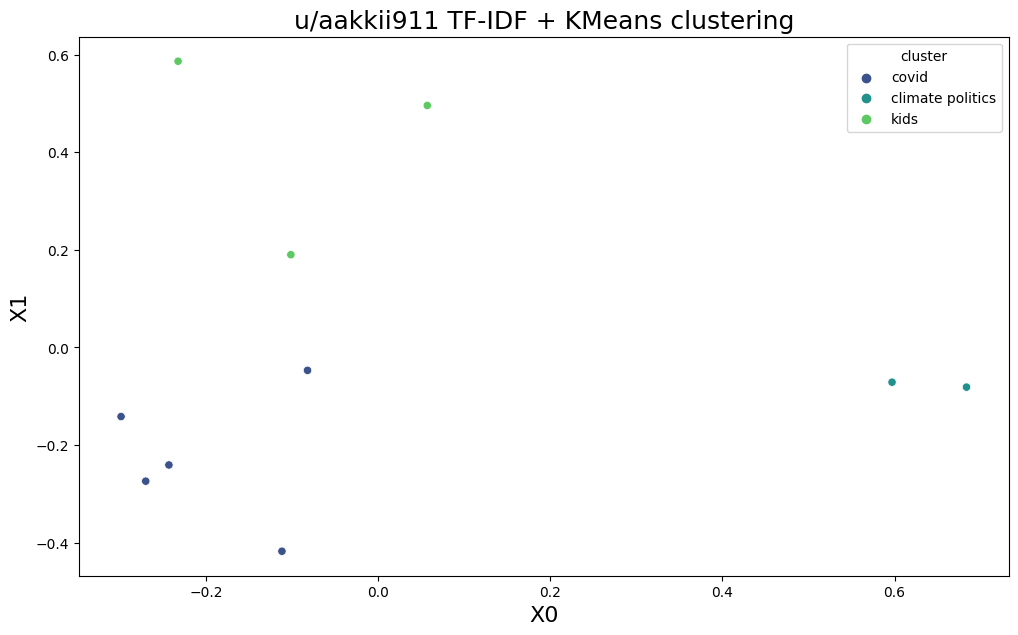

In [22]:
# TF-IDF analysis for each user
# code retrieved and modified from https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7 and https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
from pathlib import Path  
import glob2 as glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords

def preprocess_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

# files for specific user tfidf
directory_path = r"C:\Users\wannl\OneDrive\Documents\Classes\HON498\code\conspiracy\aakkii911"
csv_files = glob.glob(f"{directory_path}\*")
csv_titles = [Path(text).stem for text in csv_files]

# create tfidf dataframe and save to file
tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words='english')
tfidf_vector = tfidf_vectorizer.fit_transform(csv_files) # calc tfidf
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=csv_titles, columns=tfidf_vectorizer.get_feature_names_out())

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(tfidf_vector)
# store cluster labels in a variable
clusters = kmeans.labels_
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(tfidf_vector.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

tfidf_df['cluster'] = clusters
tfidf_df['x0'] = x0
tfidf_df['x1'] = x1

def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(tfidf_vector.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = tfidf_vectorizer.get_feature_names_out() # access tf-idf terms
    outfile = open(r"C:\Users\wannl\OneDrive\Documents\Classes\HON498\code\conspiracy\aakkii911_tfidf_clusters", "a+")
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
        outfile.write('\nCluster {}'.format(i) + '\n')
        outfile.write(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]) + '\n')

get_top_keywords(10) # save output of top 10 keywords for each cluster to file

# map clusters to appropriate labels 
cluster_map = {0: "infowars", 1: "media", 2: "china"}
# apply mapping
tfidf_df['cluster'] = tfidf_df['cluster'].map(cluster_map)

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("u/aakkii911 TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=tfidf_df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.savefig(r"C:\Users\wannl\OneDrive\Documents\Classes\HON498\code\conspiracy\aakkii911_tfidf", bbox_inches='tight')
plt.show()